In [1]:
import importlib

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils
from Utils import plot_utils
from Utils import common_functions
importlib.reload(plot_utils)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [40]:
clinical_ph = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")['ph']
clinical_ph

1001    7.14
1002    7.00
1003    7.20
1004    7.30
1005    7.30
        ... 
2042    7.33
2043    7.08
2044    7.02
2045    7.03
2046    7.01
Name: ph, Length: 552, dtype: float64

In [41]:
# .apply(lambda x: 0 if x >= 7.2 else 1)
# >= 7.2 normal // < 7.2 patologico
clinical_ph_0 = clinical_ph[clinical_ph >= 7.2]
clinical_ph_1 = clinical_ph[clinical_ph < 7.2]

clinical_ph_0.shape, clinical_ph_1.shape

((375,), (177,))

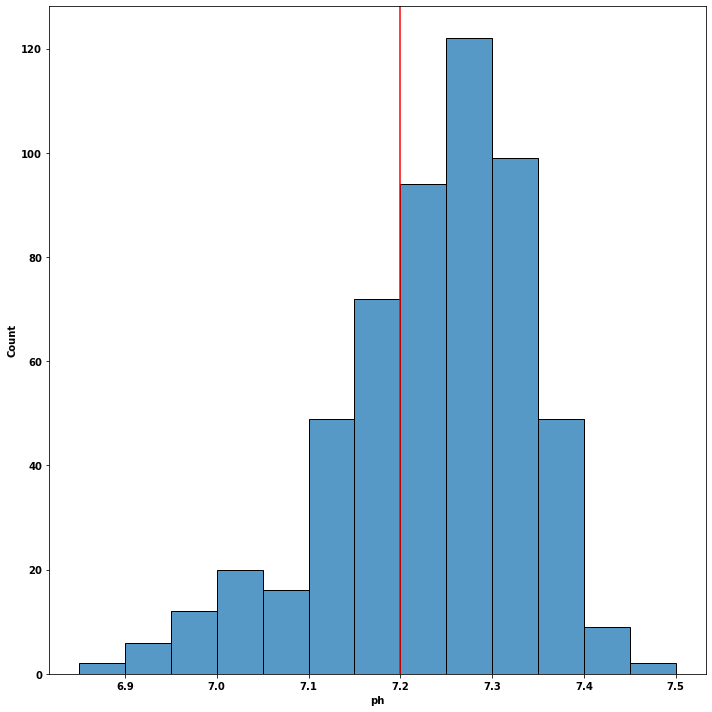

In [42]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(7.2, color='red')
fig.tight_layout()

In [43]:
prop_0 = clinical_ph_0.shape[0] / clinical_ph.shape[0]
prop_1 = clinical_ph_1.shape[0] / clinical_ph.shape[0]

prop_0, prop_1

(0.6793478260869565, 0.32065217391304346)

(7.18, 7.22)

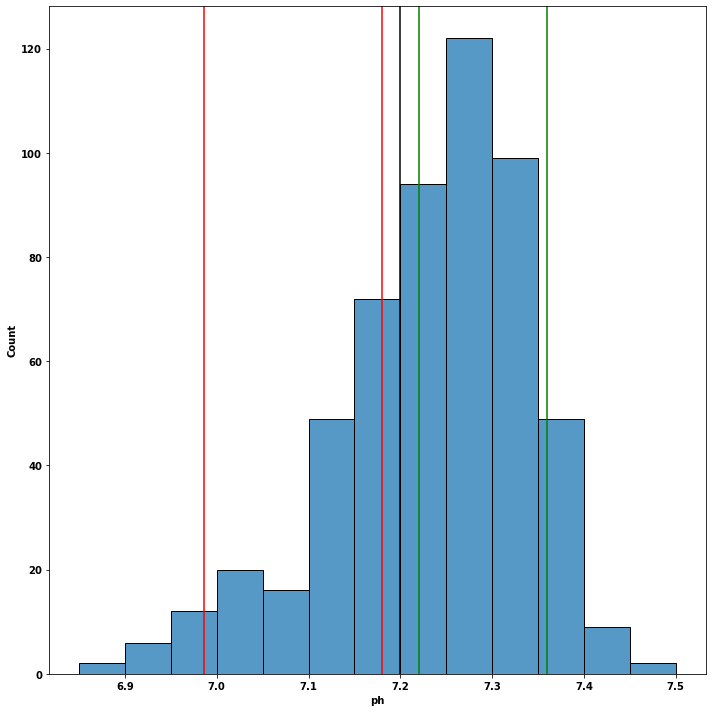

In [44]:
fig, ax = plt.subplots(1,  1, figsize=(10, 10))
sns.histplot(clinical_ph, binwidth=0.05, ax=ax)
ax.axvline(clinical_ph_0.quantile(0.1), color='green')
ax.axvline(clinical_ph_0.quantile(0.9), color='green')
ax.axvline(clinical_ph_1.quantile(0.9), color='red')
ax.axvline(clinical_ph_1.quantile(0.1), color='red')
ax.axvline(7.2, color='black')
fig.tight_layout()

clinical_ph_1.quantile(0.9), clinical_ph_0.quantile(0.1)

In [47]:
removed = clinical_ph[(7.15 >= clinical_ph) & (clinical_ph <= 7.20)]
removed.shape[0] / clinical_ph.shape[0]

1001    7.14
1002    7.00
1014    7.14
1017    7.00
1018    7.09
        ... 
2030    7.04
2043    7.08
2044    7.02
2045    7.03
2046    7.01
Name: ph, Length: 113, dtype: float64

In [49]:
before_dismissed = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
                    1327, 1451, 1477, 1482, 2003]
removed_index = removed.index.to_list()
removed_index = set(removed_index).union(set(before_dismissed))
removed_index = np.array(list(removed_index))
removed_index.shape

(125,)

In [50]:
fhr = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr.shape, uc.shape, y.shape

((552, 21620), (552, 21620), (552,))

In [51]:
clean_fhr = fhr.drop(removed_index)
clean_uc = uc.drop(removed_index)
y_clean = y.drop(removed_index)
clean_fhr.shape, clean_uc.shape, y_clean.shape

((427, 21620), (427, 21620), (427,))

1003    0
1004    0
1005    0
1006    0
1008    0
       ..
2038    0
2039    0
2040    0
2041    0
2042    0
Name: ph, Length: 366, dtype: int64

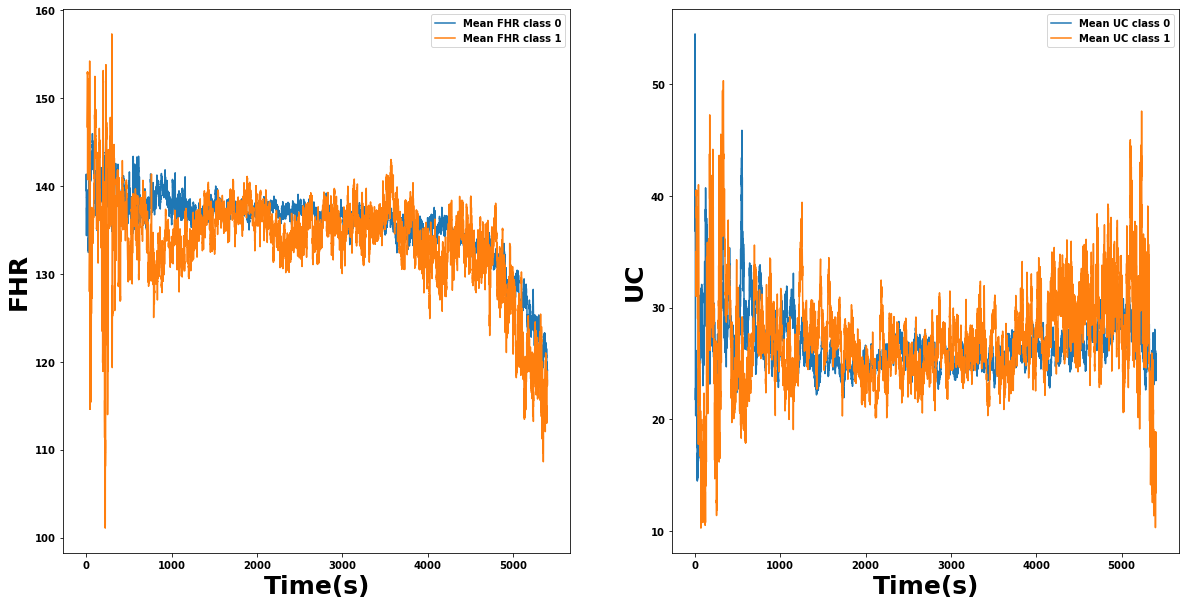

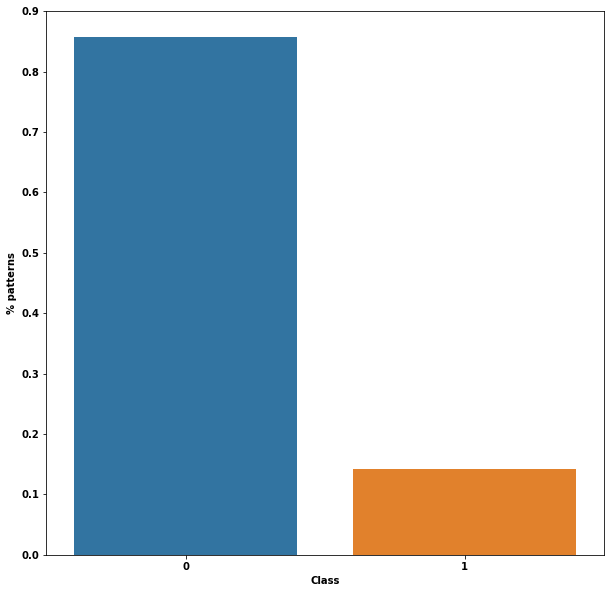

In [52]:
plot_utils.plot_fhr_uc(clean_fhr, clean_uc, y_clean)
plot_utils.plot_class_proportion(y_clean)

In [65]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 3000) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/427 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1003,-0.169003,-0.167530,-0.165941,-0.164509,-0.163056,-0.161751,-0.160551,-0.160393,-0.160192,-0.159970,...,0.019217,0.019540,0.019278,0.019167,0.018870,0.018258,0.017509,0.016931,0.016199,0.015650
1004,0.011775,0.010709,0.009421,0.007845,0.006370,0.005518,0.005287,0.004886,0.004552,0.004915,...,-0.135158,-0.134690,-0.133797,-0.133298,-0.132531,-0.131928,-0.131086,-0.130169,-0.129447,-0.128523
1005,-0.126280,-0.126069,-0.125784,-0.125867,-0.125825,-0.125499,-0.124934,-0.124543,-0.123750,-0.123181,...,-0.006627,-0.006341,-0.005711,-0.005226,-0.005344,-0.005489,-0.005640,-0.005584,-0.005516,-0.005679
1006,0.011752,0.015884,0.015719,0.016986,0.017949,0.018932,0.020794,0.020823,0.020344,0.015404,...,0.093530,0.094747,0.097826,0.101300,0.103749,0.106475,0.107071,0.105926,0.104626,0.105933
1007,0.174093,0.173421,0.172698,0.172030,0.171464,0.170872,0.170371,0.169805,0.169336,0.168853,...,-0.123964,-0.123574,-0.123290,-0.122659,-0.122082,-0.121809,-0.121113,-0.120381,-0.119386,-0.118067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,0.018352,0.019813,0.021788,0.023428,0.024697,0.025640,0.026400,0.027041,0.027319,0.027457,...,-0.034835,-0.035476,-0.035923,-0.036220,-0.036518,-0.036989,-0.037167,-0.037260,-0.037060,-0.036576
2039,-0.011355,-0.011141,-0.011028,-0.010743,-0.010628,-0.010146,-0.009736,-0.009198,-0.008306,-0.007709,...,0.043505,0.046315,0.049439,0.052912,0.056425,0.059394,0.062422,0.064806,0.067454,0.069939
2040,-0.189987,-0.191358,-0.192488,-0.193322,-0.194312,-0.195447,-0.196743,-0.197863,-0.198947,-0.200139,...,-0.111217,-0.112454,-0.114215,-0.115729,-0.117222,-0.118632,-0.120123,-0.121481,-0.122836,-0.124534
2041,0.006330,0.005324,0.004203,0.002887,0.001586,0.000399,-0.000863,-0.002248,-0.003795,-0.005521,...,0.033055,0.032924,0.032829,0.032727,0.032663,0.032644,0.032638,0.032696,0.032828,0.032975


In [66]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [67]:
cc_df = cc_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cc_df.shape, y_clean.shape

((427, 2399), (427,))

In [68]:
cdcor_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(clean_fhr.copy().iterrows(), clean_uc.copy().iterrows()), total=len(clean_uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cdcor_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 3000)
        for lag in lags
    )
cdcor_df = pd.DataFrame(cdcor_data).T
cdcor_df.columns = lags
cdcor_df

  0%|          | 0/427 [00:00<?, ?it/s]

,-1199,-1198,-1197,-1196,-1195,-1194,-1193,-1192,-1191,-1190,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
1003,0.162816,0.162256,0.161569,0.160944,0.160239,0.159661,0.159059,0.158984,0.158743,0.158378,...,0.085547,0.085014,0.084481,0.083886,0.083346,0.082789,0.082171,0.081537,0.080665,0.079805
1004,0.113373,0.113774,0.114102,0.114211,0.114659,0.115114,0.115175,0.115475,0.115971,0.116520,...,0.179583,0.179500,0.179391,0.179345,0.179100,0.178829,0.178438,0.178080,0.177652,0.177054
1005,0.242651,0.242835,0.243133,0.243841,0.244312,0.244256,0.244066,0.244242,0.243950,0.244043,...,0.157983,0.157987,0.157851,0.157704,0.157901,0.158041,0.158127,0.157934,0.157745,0.157743
1006,0.146380,0.144018,0.143483,0.142895,0.143252,0.144087,0.144774,0.144527,0.144081,0.143624,...,0.133232,0.133630,0.134726,0.135021,0.135974,0.137754,0.138588,0.139049,0.139179,0.139841
1007,0.221147,0.221571,0.221995,0.222673,0.223237,0.223780,0.224416,0.224911,0.225434,0.225977,...,0.132649,0.131665,0.130666,0.129967,0.129640,0.129464,0.129837,0.129709,0.129381,0.128778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,0.051071,0.051369,0.051918,0.052395,0.052516,0.052599,0.052721,0.052837,0.052846,0.052929,...,0.078087,0.078134,0.078131,0.078284,0.078407,0.078415,0.078359,0.078304,0.078190,0.078151
2039,0.237152,0.236932,0.236676,0.236376,0.236021,0.235555,0.235114,0.234803,0.234264,0.233908,...,0.179710,0.180672,0.181772,0.183038,0.184400,0.185506,0.186980,0.187878,0.189041,0.189999
2040,0.238741,0.239603,0.240410,0.240980,0.241558,0.242105,0.242744,0.243221,0.243645,0.244308,...,0.198984,0.199178,0.199598,0.199898,0.199876,0.199626,0.199725,0.199618,0.199467,0.199676
2041,0.133774,0.133501,0.133212,0.133083,0.132991,0.132763,0.132621,0.132489,0.132502,0.132675,...,0.113226,0.112584,0.111965,0.111299,0.110548,0.109801,0.109195,0.108638,0.108109,0.107779


In [69]:
bad_idx = cdcor_df.index[cdcor_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([], dtype='int64')

In [70]:
cdcor_df = cdcor_df.drop(bad_idx, errors='ignore')
tt = np.array(lags)
cdcor_df.shape, y_clean.shape

((427, 2399), (427,))

In [71]:
fft_data = dict()
freqs = t_utils.get_freqs(fhr.shape[-1])

for idx_fhr, fhr_row in tqdm(clean_fhr.copy().iterrows(), total=len(clean_fhr)):
    fhr_signal = fhr_row.values

    fft_data[idx_fhr] = t_utils.nan_save_fft(fhr_signal, freqs)

  0%|          | 0/427 [00:00<?, ?it/s]

In [72]:
fft_df = pd.DataFrame(fft_data).T
fft_df.columns = freqs
fft_df = fft_df.loc[:, freqs <= 0.1]
fft_df = fft_df.iloc[:, 1:]
freqs = np.array(freqs)[freqs <= 0.1][1:]
fft_df

,0.000185,0.000370,0.000555,0.000740,0.000925,0.001110,0.001295,0.001480,0.001665,0.001850,...,0.098242,0.098427,0.098612,0.098797,0.098982,0.099167,0.099352,0.099537,0.099722,0.099907
1003,7.855275e+05,3.803361e+05,672167.943326,449903.237109,372471.492101,142409.392588,35295.210275,119387.158496,102855.604442,65969.044909,...,5527.056870,9437.496038,7364.281425,11188.066864,7480.969788,9602.741490,3423.256223,9843.431465,10271.469361,6476.379852
1004,8.480775e+05,6.447865e+05,283623.313506,86750.269146,138050.781488,126548.681553,141234.326064,71740.536818,50350.172330,78410.132774,...,5529.865013,3223.492709,2735.773744,2317.109110,3376.993304,1431.849621,3739.614016,3117.085007,938.478442,4249.392013
1005,9.892601e+05,5.393654e+05,80580.461556,122561.687447,216241.769749,185922.620633,58610.383669,107677.337489,187617.522019,63404.422816,...,23445.906317,18857.814708,6254.031696,19501.097850,6394.706805,15407.872449,5895.693264,21997.771557,8787.444150,18517.452077
1006,4.834163e+05,1.374470e+06,290356.427143,453006.818055,407102.491515,106538.466408,136141.123892,191817.312525,157409.717464,175877.783795,...,23865.410816,20216.652548,17780.665443,9526.864181,6049.382204,8238.441896,10245.902187,16277.270298,18315.970316,17123.789017
1007,1.146829e+06,7.410124e+05,530430.877953,663833.601020,517387.755723,266028.688112,223168.103937,118852.032803,124898.976867,35096.762699,...,11295.634632,2292.211417,937.499724,13490.486588,2365.091494,7289.432680,2620.130546,2889.352126,5516.837588,6075.376820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,1.373468e+06,5.837960e+05,125084.445261,280946.183367,347569.331035,57229.379304,247454.690599,195179.874973,28013.434818,135414.580331,...,5474.170503,2373.523734,1801.028121,3476.872306,2100.566841,3351.237599,1249.041943,4168.569547,4411.525907,5739.703302
2039,1.715721e+06,5.557164e+04,580180.493658,51896.157636,371295.094281,60731.311483,275653.914632,21922.466034,212729.717733,14289.129046,...,5128.713257,1524.089330,3468.755761,5316.198209,3667.970974,1810.736340,5442.589506,2694.208558,4544.546355,5457.406815
2040,1.579261e+06,7.696858e+05,12469.600518,395381.393482,323291.073163,16732.828978,227567.283416,204521.566653,33230.245349,187670.416331,...,2594.219041,5240.126738,4625.219245,5230.148018,4999.448495,915.252298,4873.495026,523.343559,3969.882446,3598.539419
2041,1.360081e+06,7.121760e+05,29826.749387,331773.689152,278366.259607,48589.176923,207932.837283,170987.369303,16788.475687,152283.130332,...,10521.304595,3873.620745,5745.238678,6278.818335,9110.764010,7452.837924,5965.946568,13787.328042,7076.264797,1914.586368


In [73]:
cc_df.to_csv(f"{paths.CC_DATA_PATH}/easy_cc_dataset.csv")
cc_df['patologico'] = y_clean
X = cc_df.iloc[:, :-1]
X.to_pickle(f"{paths.CC_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.CC_DATA_PATH}/easy_y.pickle")

In [74]:
cdcor_df.to_csv(f"{paths.CDCOR_DATA_PATH}/easy_dcor_dataset.csv")
cdcor_df['patologico'] = y_clean
X = cdcor_df.iloc[:, :-1]
X.to_pickle(f"{paths.CDCOR_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.CDCOR_DATA_PATH}/easy_y.pickle")

In [75]:
fft_df.to_csv(f"{paths.FFT_DATA_PATH}/easy_fft_dataset.csv")
fft_df['patologico'] = y_clean
X = fft_df.iloc[:, :-1]
X.to_pickle(f"{paths.FFT_DATA_PATH}/easy_X.pickle")
y_clean.to_pickle(f"{paths.FFT_DATA_PATH}/easy_y.pickle")

In [2]:
y_clean = pd.read_pickle(f"{paths.CC_DATA_PATH}/easy_y.pickle")

cc_df = pd.read_csv(f"{paths.CC_DATA_PATH}/easy_cc_dataset.csv", index_col=0)
cdcor_df = pd.read_csv(f"{paths.CDCOR_DATA_PATH}/easy_dcor_dataset.csv", index_col=0)
fft_df = pd.read_csv(f"{paths.FFT_DATA_PATH}/easy_fft_dataset.csv", index_col=0)

tt = cc_df.columns.astype('int')
freqs = fft_df.columns.astype('float64')

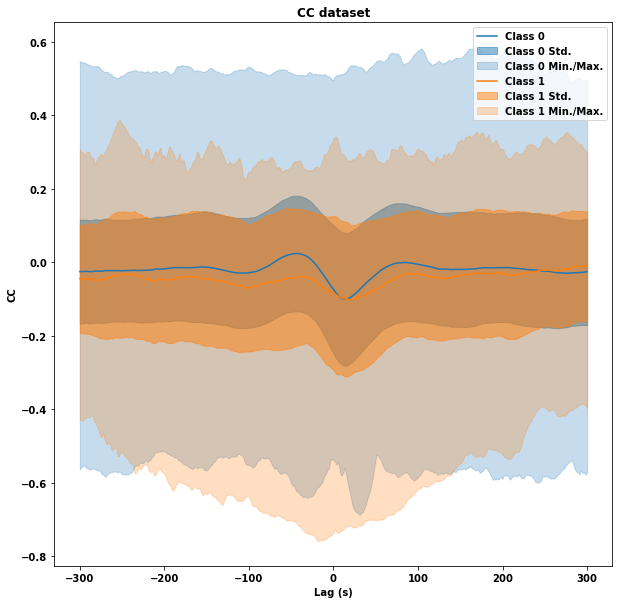

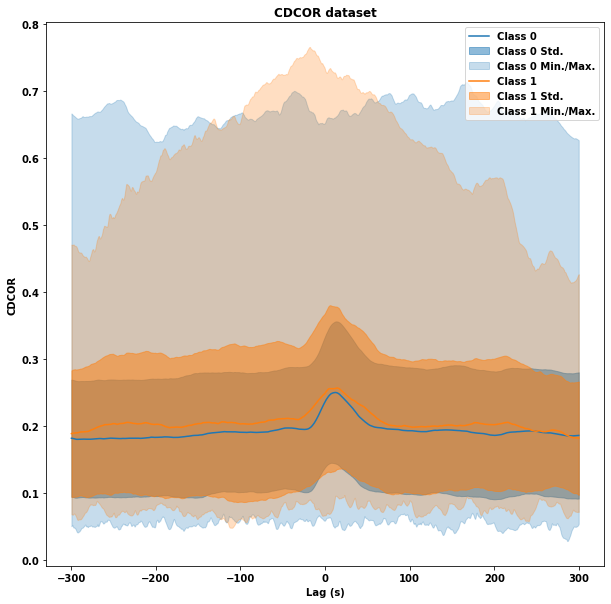

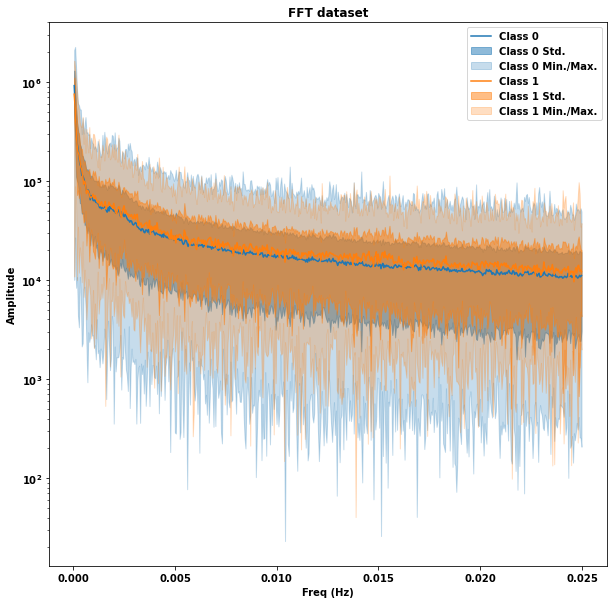

In [3]:
plot_utils.plot_data_desc(tt, cc_df, y_clean, f'CC dataset', 'CC')
plot_utils.plot_data_desc(tt, cdcor_df, y_clean, f'CDCOR dataset', 'CDCOR')
plot_utils.plot_data_desc(freqs, fft_df, y_clean, f'FFT dataset', 'Amplitude', fourier=True)
#

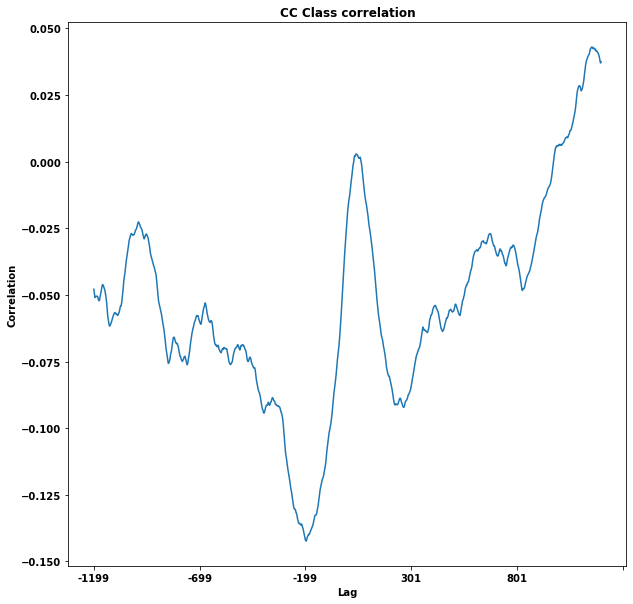

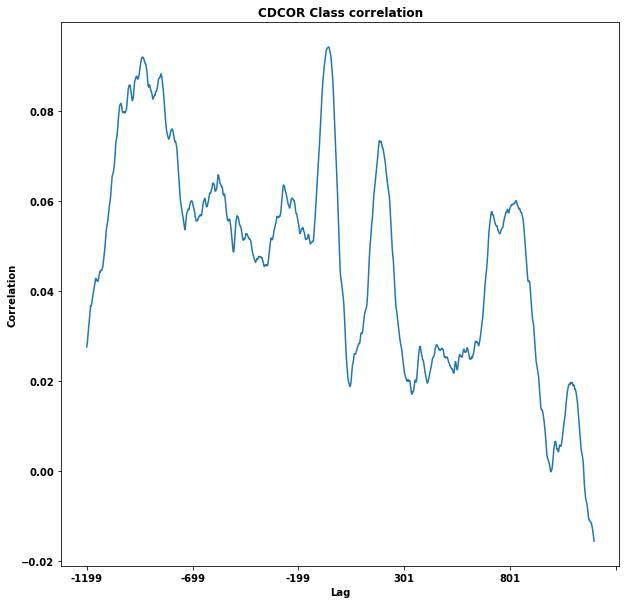

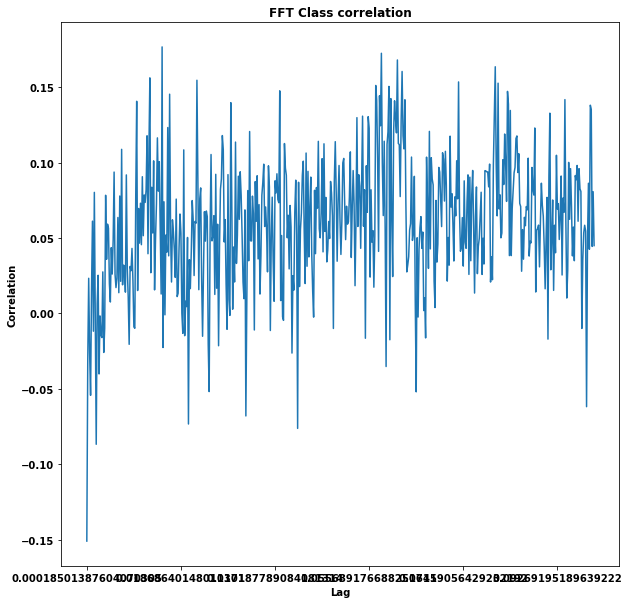

In [4]:
plot_utils.plot_class_correlation(cc_df, y_clean, title=f'CC Class correlation')
plot_utils.plot_class_correlation(cdcor_df, y_clean, title=f'CDCOR Class correlation')
plot_utils.plot_class_correlation(fft_df, y_clean, title=f'FFT Class correlation')

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/2399 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

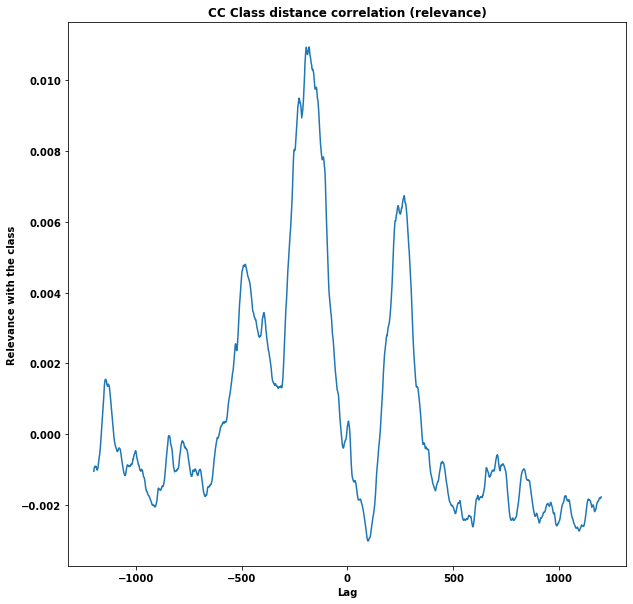

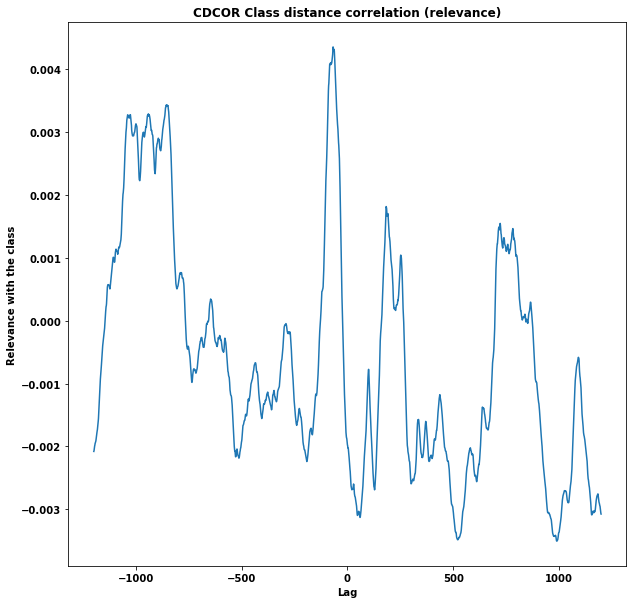

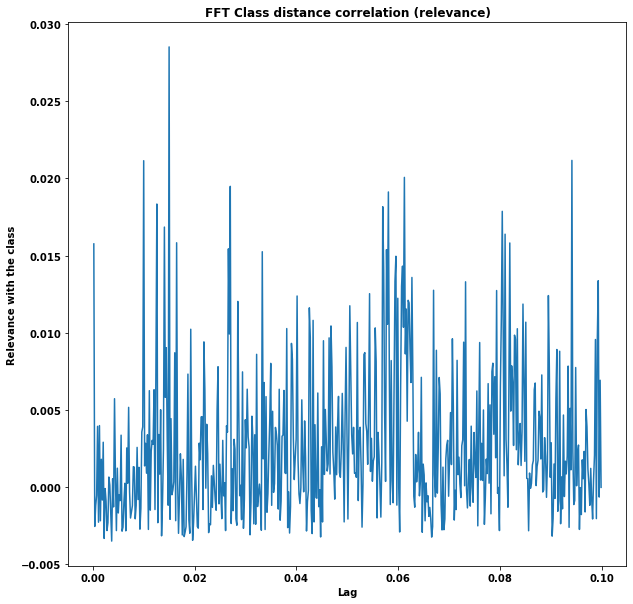

In [5]:
plot_utils.plot_relevance(cc_df, y_clean, title=f'CC Class distance correlation (relevance)')
plot_utils.plot_relevance(cdcor_df, y_clean, title=f'CDCOR Class distance correlation (relevance)')
plot_utils.plot_relevance(fft_df, y_clean, title=f'FFT Class distance correlation (relevance)')

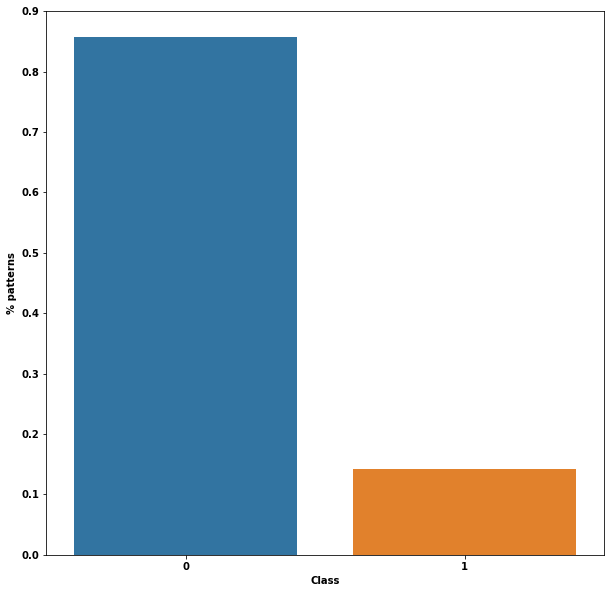

In [6]:
plot_utils.plot_class_proportion(y_clean)